In [37]:
## Ch. 13 


    Loading and Preprocessing Data with Tensorflow
    
1. The Data Api
2. TFRecord Format
3. TF Transform
4. TF Datasets

In [2]:
# Setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [39]:
### 13.1 The Data Api

# create Dataset

X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)

# equivalently
dataset = tf.data.Dataset.range(10)

## 13.1.1 Chaining Transformation

In [40]:

# tf.data methods not modify dataset always creates new dataset
dataset = dataset.repeat(3).batch(7)

# map(each item in dataset), apply & filter(whole dataset)
dataset = dataset.map(lambda x: x * 2)
dataset = dataset.apply(tf.data.experimental.unbatch()) # alreadz deprecated now in tf.data.Dataset
dataset = dataset.filter(lambda x: x < 10)

# to have a look at a piece of dataset

for item in dataset.take(3):
    print(item)


tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


## 13.1.2 Shuffling the Data

In [41]:
# Gradient Descent works best when training set are independent and identically distributed

dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size = 5, seed = 5).batch(7)

for item in dataset:
    print(item)

tf.Tensor([3 4 0 1 2 6 8], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 4 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([8 0 7 9 0 3 6], shape=(7,), dtype=int64)
tf.Tensor([5 1 7 6 9 8 4], shape=(7,), dtype=int64)
tf.Tensor([5 2], shape=(2,), dtype=int64)


In [42]:
# Attention
# if you call repeat() on shuffled dataset, it will be reshuffeled
# if not needed parameter reshuffle_each_iteration = False!


# other shuffle approaches

# shuffle whole source data
# split source and read in parts randomly
# 

### Interleaving lines from multiple files

california housing data




In [43]:
# prepare data

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# get the data
housing = fetch_california_housing()

# split in train/test, then train into train/valid
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

# split file in multiple files (not fit to memory)
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)


In [44]:
# lets look at those csv

import pandas as pd

pd.read_csv(train_filepaths[0]).head()

# in text mode

with open(train_filepaths[0]) as f:
    for x in range(5):
        print(f.readline(), end="")


MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [45]:
## Building an Input Pipeline

# 1) combine all filepaths into 1 dataset
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed= 42)

# 2) interleave
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

# takes in 5 .csv, skips the first row, takes a line randomly, goes next .csv until all lines finished.
# then takes 5 .csv again until all .csv parts finished


In [46]:
for line in dataset.take(5):
    print(line.numpy())

b'4.7361,7.0,7.464968152866242,1.1178343949044587,846.0,2.694267515923567,34.49,-117.27,1.745'
b'3.6641,17.0,5.577142857142857,1.1542857142857144,511.0,2.92,40.85,-121.07,0.808'
b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'
b'2.3,25.0,5.828178694158075,0.9587628865979382,909.0,3.1237113402061856,36.25,-119.4,1.328'


In [47]:
# function for preprocessing the values (standardize)
n_inputs = 8 # X_train.shape[-1]

@tf.function

def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype= tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults = defs)
    x = tf.stack(fields[:-1]) # to make a tf vector out of skalar
    y = tf.stack(fields[-1:]) # same, vector with only 1 value
    return (x - X_mean) / X_std, y


In [48]:
# test preproccess function

preprocess(b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([-0.19397889, -1.0778131 , -0.9433855 ,  0.01485314,  0.02073333,
        -0.5729162 ,  0.9292612 , -1.4221538 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.442], dtype=float32)>)

### Create Pipeline for preprocessing with all together


In [49]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1) #while still training on batch, preprocessing new batch

In [50]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



## Using the datasets on an ANN


In [51]:
# 1) create the datasets

train_set = csv_reader_dataset(train_filepaths, repeat = None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

# clear session and set seed for reproducible results

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# create model

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [52]:
# compile

model.compile(loss="mse",
             optimizer=keras.optimizers.SGD(lr = 0.01),
             metrics= [])
# train model

batch_size = 32
model.fit(train_set, steps_per_epoch = len(X_train) // batch_size, epochs = 10,
         validation_data = valid_set) # normally numpy array with (X_train, y_train and (X_valid, y_valid)) now TF DAtaset


Train for 362 steps
Epoch 1/10
362/362 [==============================] - 3s 8ms/step - loss: 0.6834 - val_loss: 0.6064
Epoch 2/10
362/362 [==============================] - 2s 4ms/step - loss: 0.4902 - val_loss: 44.9670
Epoch 3/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7033 - val_loss: 5.6295
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7134 - val_loss: 0.3923
Epoch 5/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4030 - val_loss: 0.3669
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4141 - val_loss: 0.3624
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.3719 - val_loss: 0.3533
Epoch 8/10
362/362 [==============================] - 1s 3ms/step - loss: 0.3708 - val_loss: 0.3491
Epoch 9/10
362/362 [==============================] - 1s 4ms/step - loss: 0.3781 - val_loss: 0.3460
Epoch 10/10
362/362 [==============================] - 1s 4ms/step - loss: 0.38

In [53]:
model.evaluate(test_set, steps = len(X_test) // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.3672


0.3672311701204466

In [54]:
# predict (we pretend)
new_set = test_set.map(lambda X, y: X) # also possible just test_set keras on its own would only take the X_values

X_new = X_test
model.predict(new_set, steps = len(X_new) // batch_size)

array([[1.9873317],
       [1.9869726],
       [1.5544806],
       ...,
       [0.7870678],
       [4.096443 ],
       [1.0584328]], dtype=float32)

## Be Careful ! Different results than in Master File 

In [55]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [56]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


## Ch. 13.2 TFRecord binary format


In [59]:
# write a .tfrecord

with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b"Thisi is the first record")
    f.write(b"And this is the second record")


In [60]:

# read the data 

filepath = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepath)

for item in dataset:
    print(item)

tf.Tensor(b'Thisi is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [61]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [62]:
# compression (if on same Computer don"t need since comput. power for decrompression, if needed to download compress)

options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [63]:
# if compress need to specifiy when reading
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### A Brief Intro to Protocol Buffers

Protocol Buffers (a.k.a., protobuf) are Google's language-neutral, platform-neutral, extensible mechanism for serializing structured data. You can find protobuf's documentation on the Google Developers site.

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads). In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type `tf.train.Example`, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

lets write a simple protobuf definition



In [64]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


In [65]:
# And let's compile it (the `--descriptor_set_out` and `--include_imports` options 
# are only required for the `tf.io.decode_proto()` example below):

!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [66]:
!ls person*

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [67]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [68]:
person.name # read a file

'Al'

In [69]:
person.name = "Alice" # modify a field

In [70]:
person.email[0]  # repeated fields can be accessed like arrays
person.email.append("c@d.com")  # add an email address

s = person.SerializeToString()
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [72]:
person2 = Person() # create a new person
person2.ParseFromString(s) # parse the byte string

27

In [73]:
person == person2  # now they are equal

True

#### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [74]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

### TensorFlow Protobufs
Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

**Warning**: there's currently a bug preventing `from tensorflow.train import X` so we work around it by writing `X = tf.train.X`. See https://github.com/tensorflow/tensorflow/issues/33289 for more details.

In [6]:
#from tensorflow.train import BytesList, FloatList, Int64List
#from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [77]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [78]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2e72e367e88>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

[[[174 201 231]
  [174 201 231]
  [174 201 231]
  ...
  [250 251 255]
  [250 251 255]
  [250 251 255]]

 [[172 199 229]
  [173 200 230]
  [173 200 230]
  ...
  [251 252 255]
  [251 252 255]
  [251 252 255]]

 [[174 201 231]
  [174 201 231]
  [174 201 231]
  ...
  [252 253 255]
  [252 253 255]
  [252 253 255]]

 ...

 [[ 88  80   7]
  [147 138  69]
  [122 116  38]
  ...
  [ 39  42  33]
  [  8  14   2]
  [  6  12   0]]

 [[122 112  41]
  [129 120  53]
  [118 112  36]
  ...
  [  9  12   3]
  [  9  15   3]
  [ 16  24   9]]

 [[116 103  35]
  [104  93  31]
  [108 102  28]
  ...
  [ 43  49  39]
  [ 13  21   6]
  [ 15  24   7]]]


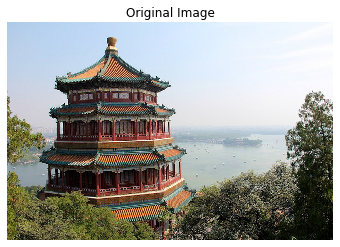

In [80]:
### Putting Images in TFRecords

from sklearn.datasets import load_sample_images
from PIL import Image

img = load_sample_images()["images"][0]
print(img)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

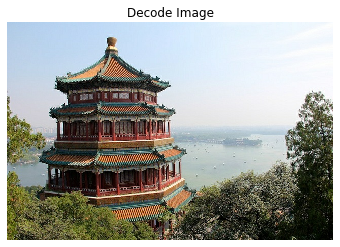

In [14]:
# save image as Exmpale TFRecord

data = tf.io.encode_jpeg(img)

example_with_image = Example(features = Features(feature = { 'image': Feature(bytes_list = BytesList(value = [data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()

# decode to show image
# clarify feature description
feature_description = { 'image': tf.io.VarLenFeature(tf.string)}

example_with_image2 = tf.io.parse_single_example(serialized_example, feature_description)

decode_img = tf.io.decode_jpeg(example_with_image2['image'].values[0]) # .decode_image() also possible
plt.imshow(decode_img)
plt.title("Decode Image")
plt.axis("off")
plt.show()

In [84]:
### skipping the rest of TFRecord part here

## The Features API



In [85]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [86]:
fetch_housing_data()

In [87]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [88]:
 housing_media_age = tf.feature_column.numeric_column('housing_media_age')

In [89]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [97]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [98]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

## Exercise 

Nr. 9

- load fashion mnist
- split train, test, valid set
- shuffle train set
- each set to multiple TFRecord files

In [56]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [87]:
y_train[:5]
X_train[0].shape

(28, 28)

(28, 28)


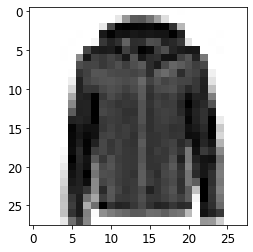

In [58]:
img = X_train[0]
print(X_train[0].shape)
plt.imshow(img, cmap="Greys")

In [84]:
# create Dataset from tensors
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [85]:
for image, label in train_set.take(1):
    print(image)
    print(label)

tf.Tensor(
[[  0   0   0   0   0   0   0   0   0   0  60 121  74  53  53  44 119 128
   18   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  45 134 201 191 210 231 244 249 247 238 196
  219 203 142  28   0   0   0   0   0   0]
 [  0   0   0   0   0   0 146 203 201 191 188 180 176 182 185 187 175 180
  185 190 198 193  60   0   0   0   0   0]
 [  0   0   0   0   0  76 210 190 188 191 193 194 189 182 184 185 188 187
  185 185 180 191 170   0   0   0   0   0]
 [  0   0   0   0   0 160 200 194 195 191 195 193 188 187 190 183 184 185
  185 185 184 175 190  30   0   0   0   0]
 [  0   0   0   0   0 190 194 197 196 193 194 190 189 187 183 185 182 185
  187 188 188 175 196  58   0   0   0   0]
 [  0   0   0   0   0 202 196 203 197 190 194 195 191 188 184 183 183 183
  183 184 181 187 201  90   0   0   0   0]
 [  0   0   0   0   0 228 200 210 207 193 191 193 187 183 183 183 183 181
  177 181 193 195 198 121   0   0   0   0]
 [  0   0   0   0   0 232 203 221 249 211 197 197 190

In [65]:
#from tensorflow.train import BytesList, FloatList, Int64List
#from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example


def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label.numpy()])),
            }))

In [66]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [ ]:

# function to split dataset into multipe TFRecords with Example Protobuf

from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05}-of-{:05}".format(name, index, n_shards) for index in range(n_shards)]
    
    with ExitStack() as stack:
        writers = [ stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

## Exercise No.10



In [67]:

from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
 
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract= True)

path = Path(filepath).parent / "aclImdb"
path

WindowsPath('C:/Users/ansve/.keras/datasets/aclImdb')

In [68]:
# get the file directory visualized
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    " * indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)
        

aclImdb\
    README
    imdb.vocab
    imdbEr.txt
    test\
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg\
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos\
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train\
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        neg\
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos\
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup\
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...


In [69]:
# extract the train and test/valid set from data

def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / 'pos')
train_neg = review_paths(path / "train" / 'neg')

test_valid_pos = review_paths(path / "test" / 'pos')
test_valid_neg = review_paths(path / "test"/ 'neg')


# split valid and test
test_pos = test_valid_pos[:5000]
test_neg = test_valid_pos[:5000]

valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [70]:
# random shuffle & split test and valid set

np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_pos[:5000]

valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_pos[5000:]


In [79]:
# Exercise 13 c.) use tf.data to create efficient dataset

def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))
    
# test dataset 
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 194: character maps to <undefined>